# DB Puenktlichkeit
Wir starten mit ein paar imports

In [31]:
import datetime
import os
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np


module_path = os.path.abspath(os.path.join('./lib/'))
if module_path not in sys.path:
    sys.path.append(module_path)
from lib.dbahn_utils import BahnUtils


Hier den Pfad anpassen in den die paket_1_1_* zips extrahiert wurden

In [32]:
bahn_utils = BahnUtils(Path(os.path.expanduser(f'~/Downloads/')))


Wir lesen die Daten nun ein

In [13]:
# Read the data for november
folders = ['202010', '202011', '202012']
ret_folders = {}
for folder in folders:
    OUT = bahn_utils.read_data_folder(folder)
    ret_folders[folder] = OUT


# wir laden uns die daten fuer 11 2020 nochmal extra
folder = '202011'
header, data_uuids_set, filter_by_type = ret_folders[folder]
print(datetime.datetime.now(), 'data_ids length', len(data_uuids_set.keys()))

NameError: name 'bahn_utils' is not defined

### Now we try to find some interesting ID's to investigate

In [12]:
THRESHOLDS = (70, 100)
data_uuid_to_notifications = {k: v['type']['ARRIVAL_TIME_CHANGE'] for k, v in data_uuids_set.items()
                              if THRESHOLDS[0] < v['type']['ARRIVAL_TIME_CHANGE'] < THRESHOLDS[1]}

print(f'Thresholds used for selection {THRESHOLDS}')
for uid, amount_notificiations in data_uuid_to_notifications.items():
    print(f'{uid} -> {amount_notificiations} notifications with '
          f'channel_address="ARRIVAL_TIME_CHANGE": {amount_notificiations}')


Thresholds used for selection (70, 100)
51355 -> 82 notifications with channel_address="ARRIVAL_TIME_CHANGE": 82
407 -> 98 notifications with channel_address="ARRIVAL_TIME_CHANGE": 98
51536 -> 96 notifications with channel_address="ARRIVAL_TIME_CHANGE": 96
97924 -> 71 notifications with channel_address="ARRIVAL_TIME_CHANGE": 71
16611 -> 71 notifications with channel_address="ARRIVAL_TIME_CHANGE": 71
47813 -> 84 notifications with channel_address="ARRIVAL_TIME_CHANGE": 84
1549 -> 71 notifications with channel_address="ARRIVAL_TIME_CHANGE": 71
52262 -> 87 notifications with channel_address="ARRIVAL_TIME_CHANGE": 87
36780 -> 84 notifications with channel_address="ARRIVAL_TIME_CHANGE": 84
52369 -> 82 notifications with channel_address="ARRIVAL_TIME_CHANGE": 82
52241 -> 93 notifications with channel_address="ARRIVAL_TIME_CHANGE": 93
52751 -> 99 notifications with channel_address="ARRIVAL_TIME_CHANGE": 99
38645 -> 94 notifications with channel_address="ARRIVAL_TIME_CHANGE": 94
67380 -> 94 no

### Plot the distribution of notifications across app installations (only top 1000)

202010 max 13767
202010 mean 89.84404270549354 std 200.21953306390415
202010 median 33.0
202011 max 9022
202011 mean 80.43662163541703 std 174.45114956193996
202011 median 30.0
202012 max 11290
202012 mean 69.82878287672304 std 156.79144951239755
202012 median 24.0


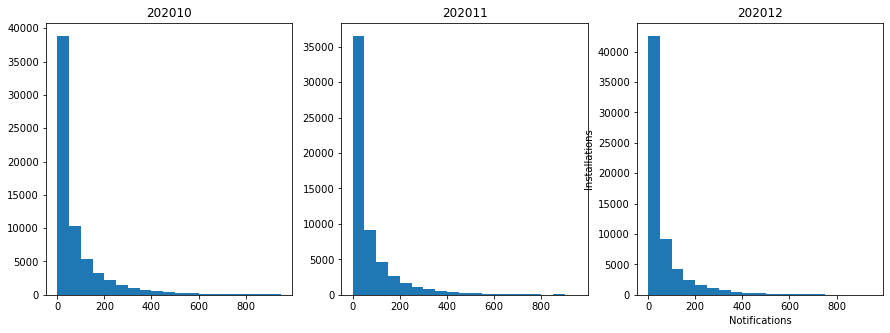

In [131]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, (folder_name, folder_data) in enumerate(ret_folders.items()):

    push_notifications = np.asarray([v['notifications'] for k, v in folder_data[1].items()])

    print(folder_name, 'max', np.max(push_notifications))
    print(folder_name, 'mean', np.nanmean(push_notifications), 'std', np.nanstd(push_notifications))
    print(folder_name, 'median', np.median(push_notifications))


    axs[i].hist(push_notifications[push_notifications < 1000], np.arange(0, 1000, 50))
    axs[i].set_title(folder_name)
    # plt.scatter(x=int(np.nanmean(push_notifications[push_notifications < 1000])), y=0)

plt.xlabel('Notifications')
plt.ylabel('Installations')

plt.show()

### Plot the distribution of different push notification types

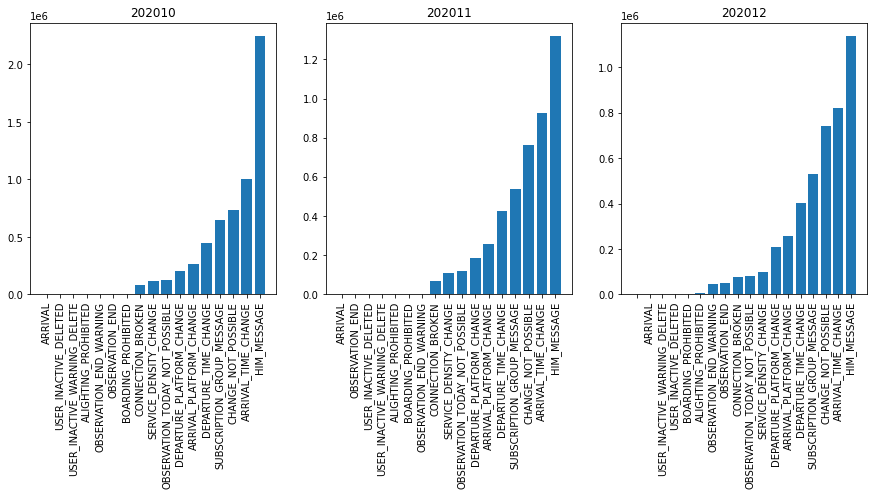

In [136]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, (folder_name, folder_data) in enumerate(ret_folders.items()):
    key_vals = [(k, v) for k, v in folder_data[2].items()]
    key_vals = sorted(key_vals, key=lambda x: x[1])


    axs[i].bar(np.arange(0, len(key_vals)), [x[1] for x in key_vals])
    axs[i].set_xticks(np.arange(0, len(key_vals)))
    axs[i].set_xticklabels([x[0] for x in key_vals], rotation=90, rotation_mode="default")
    axs[i].set_title(folder_name)
plt.show()


### Plot the number of days the users get notifications

202010 max 31
202010 mean 12.39939688390015
202010 median 11.0
202011 max 30
202011 mean 11.859104365876068
202011 median 11.0
202012 max 31
202012 mean 10.484940465945895
202012 median 9.0


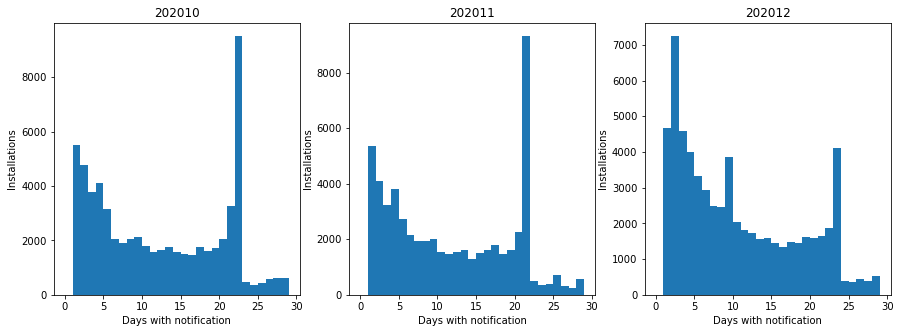

In [137]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
for i, (folder_name, folder_data) in enumerate(ret_folders.items()):
    push_notifications_per_day = np.asarray([len(v.keys()) - 2 for k, v in folder_data[1].items()])
    print(folder_name, 'max', np.max(push_notifications_per_day))
    print(folder_name, 'mean', np.nanmean(push_notifications_per_day))
    print(folder_name, 'median', np.median(push_notifications_per_day))

    axs[i].hist(push_notifications_per_day, np.arange(0, 30, 1))
    axs[i].set_xlabel('Days with notification')
    axs[i].set_ylabel('Installations')
    axs[i].set_title(folder_name)
plt.show()


### Other interesting ideas
  * Notifications by weekday
  *

In [97]:
# Specify the app_uuid which you want to export. You can add multiple ids to the list
ids_to_filter = ['51578']
# Specify the folders which shall be looked at
folders = ['202010', '202011', '202012']
# specify the channel_address types which shall be exported
channel_addresses = ['CANCELLATION', 'ARRIVAL_TIME_CHANGE', 'DEPARTURE_TIME_CHANGE']

# specify the additional fields for the folder
additional_detail_fields = ['ArrivalDelay', 'PlannedArrivalTime', 'PlannedPlatform', 'RtPlatform', 'StopId', 'StopName']


for folder in folders:
    print(f'Going through: {folder}')
    _fpath = bahn_utils.get_path(folder)

    lines_by_id = bahn_utils.filter_by_id(_fpath, ids_to_filter, channel_addresses)

    for id, lines in lines_by_id.items():
        with open(f'./output_{folder}_{id}.csv', 'w') as f:
            f.writelines(lines)


Going through: 202010
Going through: 202011
Going through: 202012


In [ ]:
# Filterung Pünktlichkeit als erstes nach: chanel_address: CANCELLATION, ARRIVAL_TIME_CHANGE (evtl auch DEPARTURE_TIME_CHANGE)
#
# Dann FIlterung welche Züge/Verbindungen überhaupt abonniert:
# mit TtConnectionEvent ArrivalStop->StopName & PlannedArrivalTime, Arrival Delay (für Pünktlichkeit) und DepartureStop->Stop Name und Planned Departure (evtl noch Departure Delay);

